<h1>HW 3</h1>

Alan Wu

### imports

In [201]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

### load data

In [202]:
bmo_data = pd.read_excel('./data/BMO.xlsx')
bns_data = pd.read_excel('./data/BNS.xlsx')
cm_data = pd.read_excel('./data/CM.xlsx')
na_data = pd.read_excel('./data/NA.xlsx')
ry_data = pd.read_excel('./data/RY.xlsx')
td_data = pd.read_excel('./data/TD.xlsx')

bmo_data.head()


,date,open,high,low,close,adjusted_close,volume
0,2018-04-18,94.84,95.60,94.75,94.99,66.0176,1142387
1,2018-04-19,95.11,95.25,94.73,95.01,66.0315,954509
2,2018-04-20,95.10,95.94,95.10,95.57,66.4207,887700
3,2018-04-23,95.81,96.41,95.77,96.17,66.8377,959144
4,2018-04-24,96.49,97.16,96.34,96.68,67.1922,940562


In [203]:
data =  {'bmo':bmo_data, 'bns':bns_data, 'cm':cm_data, 'na':na_data, 'ry':ry_data, 'td':td_data}

### 1a

In [204]:
initial_shares_map = {}
initial_capital = 2_500_000
for name, dataset in data.items(): 
    price = dataset[dataset['date'] == '2020-04-17']['close'] 
    close_price = price.values[0]
    initial_shares_map[name] = initial_capital / close_price
    print(f"The Initial Shares of {name} is {initial_shares_map[name]}")


The Initial Shares of bmo is 35719.38848406915
The Initial Shares of bns is 45913.682277318636
The Initial Shares of cm is 30902.348578491965
The Initial Shares of na is 45989.6983075791
The Initial Shares of ry is 28581.227849548417
The Initial Shares of td is 43921.29304286718


### 1b

To compute the volaility of the portfolio, we need to 

1. compute the value of the portfolio on each day leading up to the initial day 
1. compute the returns of the portfolio on each day leading up to the initial day 
1. compute the annualized volatility of the portfolio 
1. account for divididends

In [28]:
portfolio_df = pd.DataFrame(index = bmo_data.index)

In [30]:
#compute the portfolio value for each day 
for name, dataset in data.items(): 
    bank_value = dataset['adjusted_close'] * initial_shares_map[name]
    portfolio_df[name] = bank_value 

portfolio_df['Value'] = portfolio_df.sum(axis=1) 
portfolio_df = portfolio_df.drop(columns=['bmo', 'bns', 'cm', 'na', 'ry', 'td'])
portfolio_df['date'] = bmo_data['date'] 



In [31]:
portfolio_df.head()

,Value,date
0,2.441589e+07,2018-04-18
1,2.432648e+07,2018-04-19
2,2.444948e+07,2018-04-20
3,2.461406e+07,2018-04-23
4,2.464662e+07,2018-04-24


In [40]:
# Calculate log returns: ln(Pt / Pt-1)
# which is mathematically equivalent to np.log(price) - np.log(price_prev)
log_returns = np.log(portfolio_df['Value'] / portfolio_df['Value'].shift(1)).to_frame()

# If you need to keep the date column
if 'date' in portfolio_df.columns:
    log_returns['date'] = portfolio_df['date']

# Drop the first NaN value caused by the shift
log_returns = log_returns.dropna()

# Compute volatility
daily_vol = log_returns['Value'].std()
annual_vol = daily_vol * np.sqrt(252)


print(f"Annualized Volatility (Log Returns): {annual_vol}")

Annualized Volatility (Log Returns): 0.27204329894794826


### 1c

We need to estimate the value of the ADS with CAD 100 principal using monte carlo simulation. 

In [47]:
sigma = annual_vol 
s_0 = 100 
r = 0.0045 
q = 0.058
T = 5 
paths = 1000 
alpha = 0.95 
dt = 1.0

In [54]:
np.random.seed(42)

Z = np.random.normal(size=(paths,T))
drift = (r - q - 0.5 * sigma**2) * dt
vol_term = sigma * np.sqrt(dt)

S = np.zeros((paths, T))
current_S = np.full(paths, s_0)

for t in range(T):
    # Update current_S for the next step (Year t+1)
    current_S = current_S * np.exp(drift + vol_term * Z[:, t])
    S[:, t] = current_S

payoffs_PV = np.zeros(paths)
returns_list = np.zeros(paths)

#simulations
for i in range(paths):
    payoff_time = 0
    cash_flow = 0
    terminated = False
    
    # Check Autocall for Years 1 to 4
    for t_idx in range(4):
        year = t_idx + 1
        St = S[i, t_idx]
        
        if St >= s_0:
            # Autocall Event
            fixed_coupon = 16.0 * year
            
            # Participation
            # Threshold for participation is 16% * year
            pct_change_scaled = St - s_0# 100 * PctChange
            threshold_scaled = 16.0 * year
            
            bonus = 0.0
            if pct_change_scaled > threshold_scaled:
                bonus = 0.05 * (pct_change_scaled - threshold_scaled)
            
            cash_flow = 100.0 + fixed_coupon + bonus
            payoff_time = year
            terminated = True
            break
    
    # Check Maturity (Year 5) if not terminated
    if not terminated:
        year = 5
        St = S[i, 4]
        payoff_time = 5
        
        if St >= s_0:
            # Autocall at Maturity
            fixed_coupon = 16.0 * 5 # 80
            pct_change_scaled = St - s_0
            threshold_scaled = 16.0 * 5 # 80
            
            bonus = 0.0
            if pct_change_scaled > threshold_scaled:
                bonus = 0.05 * (pct_change_scaled - threshold_scaled)
            
            cash_flow = 100.0 + fixed_coupon + bonus
            
        else:
            # No Autocall
            # Check Barrier (70% of Initial)
            if St >= 0.70 * s_0:
                # Principal Protected
                cash_flow = 100.0
            else:
                # 1:1 Loss
                cash_flow = St # Since S0=100, Payoff = 100 * (St/100) = St
    
    # Discount to Present Value
    payoffs_PV[i] = cash_flow * np.exp(-r * payoff_time)
    
    # Calculate Equivalent Annually Compounded Rate of Return for Part (d)
    # (CashFlow / 100)^(1/Time) - 1
    # Note: If CashFlow is 0 (impossible here but good to check), return is -100%
    # If Time is 0 (impossible), handle error.
    ann_return = (cash_flow / 100.0)**(1.0 / payoff_time) - 1.0
    returns_list[i] = ann_return

In [55]:
#compute the expected value and the confidence interval for the expected value 
estimated_value = np.mean(payoffs_PV)
std_dev = np.std(payoffs_PV, ddof=1)
std_error = std_dev / np.sqrt(paths)
ci_lower = estimated_value - 1.96 * std_error
ci_upper = estimated_value + 1.96 * std_error

# Statistics for Part (d)
mean_return = np.mean(returns_list)
std_return = np.std(returns_list, ddof=1)

print(f"Estimated Value: {estimated_value}")
print(f"Standard Error: {std_error}")
print(f"95% CI: [{ci_lower}, {ci_upper}]")
print(f"Mean Return (Part d): {mean_return}")
print(f"Std Dev Return (Part d): {std_return}")

Estimated Value: 91.52754352551192
Standard Error: 1.3388041235423587
95% CI: [88.90348744336889, 94.15159960765494]
Mean Return (Part d): 0.02424485459934898
Std Dev Return (Part d): 0.16104074795777637


### 2a

Compute the realized volatility from the data in the simulated paths. 

In [101]:
heston_paths = pd.read_excel('./data/SimulatedPaths.xlsx')
print(heston_paths.shape)
heston_paths.head()

(500, 253)


,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,100,99.015451,100.856935,100.422875,101.995271,100.245462,98.341876,97.040609,95.314283,92.793866,...,134.623271,136.175282,134.963327,136.809929,135.987388,134.895706,134.581809,134.307092,135.143544,135.740813
1,100,100.699730,101.037596,102.337398,105.069221,106.781849,107.320818,105.574585,106.010175,109.000698,...,74.004866,74.503489,74.588510,73.386559,72.928352,72.770238,71.678621,70.918299,71.404366,69.130044
2,100,99.191113,102.181260,102.980595,102.123948,101.263491,104.802792,102.751916,102.799132,101.931464,...,65.091186,65.177768,62.611388,59.782430,57.901928,56.909642,57.938991,56.264791,56.998106,59.722879
3,100,100.558861,99.942148,102.385209,103.087325,103.254521,103.292438,104.457463,104.889835,104.722381,...,124.884133,124.975558,126.310865,128.883241,130.357653,133.285791,132.836853,132.414873,133.841798,133.769326
4,100,100.720907,99.564342,100.725705,101.793817,100.964458,101.990340,100.186642,97.315016,94.327443,...,85.185618,85.716653,87.381359,87.363197,86.168261,87.129634,85.902893,85.346438,86.329712,86.154068


In [102]:
heston_paths_t = heston_paths.T
heston_paths_t.shape 
heston_paths_t.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,99.015451,100.699730,99.191113,100.558861,100.720907,99.891553,102.292082,98.538010,98.427840,100.860531,...,100.376231,97.847916,99.981125,102.294256,102.046727,99.247806,99.290359,98.253563,98.317607,100.918012
2,100.856935,101.037596,102.181260,99.942148,99.564342,100.051043,105.695312,101.333812,96.549784,106.629716,...,101.540860,95.739000,102.114296,101.447436,103.646495,100.086331,99.915913,97.532216,95.233967,101.106832
3,100.422875,102.337398,102.980595,102.385209,100.725705,100.659749,104.749867,100.596097,94.684055,109.191864,...,102.289965,93.401031,103.323768,102.789105,106.164074,100.947943,97.703124,97.382052,96.711736,102.585887
4,101.995271,105.069221,102.123948,103.087325,101.793817,100.268563,103.309729,102.213000,94.536343,109.656704,...,102.441152,94.723936,105.880743,106.898123,103.551062,101.865458,100.762014,95.721767,98.817134,98.472124


In [103]:
log_returns = np.log(heston_paths_t / heston_paths_t.shift(1)) 
log_returns = log_returns.dropna() 

realized_variance = (log_returns ** 2).sum()

In [105]:
mean_rv = realized_variance.mean()
std_rv = realized_variance.std()


print(f"Mean Realized Variance: {mean_rv}")
print(f"Std Dev of Realized Variance: {std_rv}")

Mean Realized Variance: 0.07872207159052204
Std Dev of Realized Variance: 0.05763625955371945


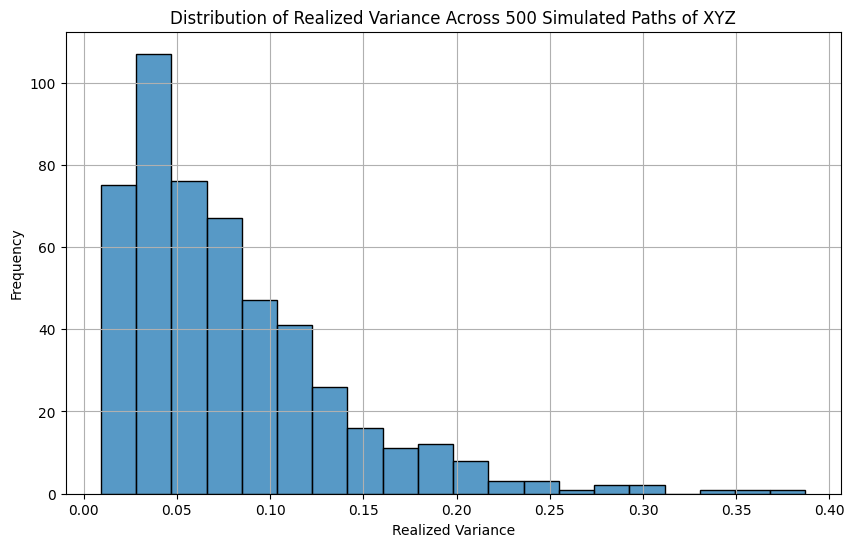

In [106]:
plt.figure(figsize=(10,6))
sns.histplot(data = realized_variance, bins = 20) 
plt.title('Distribution of Realized Variance Across 500 Simulated Paths of XYZ')
plt.xlabel('Realized Variance')
plt.ylabel('Frequency')
plt.grid() 
plt.show()

### 2b

In [132]:
from scipy.stats import norm

In [133]:
def bsm_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else: # put
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

In [134]:
S0 = 100
K = 100
T = 1.0
r = 0.05
sigma_imp = 0.27625

In [135]:
call_price = bsm_price(S0, K, T, r, sigma_imp, 'call')
put_price = bsm_price(S0, K, T, r, sigma_imp, 'put')
initial_cost = call_price + put_price
print(f"Initial straddle cost: {initial_cost}")

Initial straddle cost: 21.783734702453273


In [136]:
expiration_prices = heston_paths_t.iloc[-1]
payoffs = np.abs(expiration_prices - K)
future_costs = initial_cost * np.exp(r * T)
pnl = payoffs - future_costs

In [137]:
mean_pnl = pnl.mean() 
std_pnl = pnl.std() 

print(f"Mean PnL: {mean_pnl}")
print(f"Standard Deviation of PnL: {std_pnl}")

Mean PnL: 5.695042684774564
Standard Deviation of PnL: 20.894986671699208


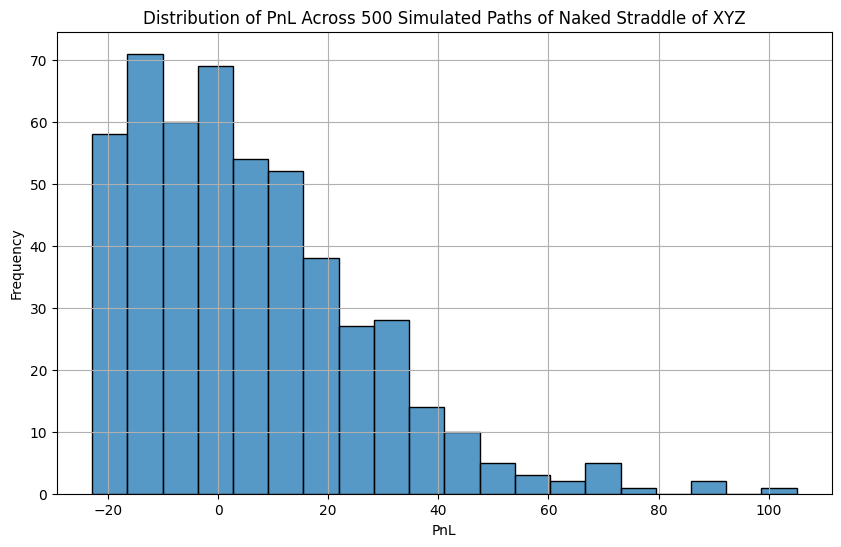

In [138]:
plt.figure(figsize=(10,6))
sns.histplot(data = pnl, bins = 20) 
plt.title('Distribution of PnL Across 500 Simulated Paths of Naked Straddle of XYZ')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.grid() 
plt.show()

### 2c

Run regressions of the cumulative pnl on thestock price on the expiration date and on the realized variance

In [140]:
import statsmodels.api as sm 

Y = pnl.values 
X_price = expiration_prices.values 
X_rv = realized_variance.values 

In [141]:
#Regression 1 
X1 = sm.add_constant(X_price)
model1 = sm.OLS(Y, X1).fit() 

print("=== Regression 1: PnL on S_T ===")
print(f"Intercept (alpha): {model1.params[0]:.4f}")
print(f"Coefficient (beta): {model1.params[1]:.4f}")
print(f"R-squared: {model1.rsquared:.4f}")
print("-" * 30)

=== Regression 1: PnL on S_T ===
Intercept (alpha): -34.5363
Coefficient (beta): 0.3458
R-squared: 0.2707
------------------------------


In [142]:
X2 = sm.add_constant(X_rv)
model2 = sm.OLS(Y, X2).fit() 

print("=== Regression 2: PnL on RV ===")
print(f"Intercept (alpha): {model2.params[0]:.4f}")
print(f"Coefficient (beta): {model2.params[1]:.4f}")
print(f"R-squared: {model2.rsquared:.4f}")
print("-" * 30)

=== Regression 2: PnL on RV ===
Intercept (alpha): 2.6594
Coefficient (beta): 38.5619
R-squared: 0.0113
------------------------------


### 2d

In [189]:
def bsm_delta(S, K, T, r, sigma):
    # Delta of Straddle = Delta_Call + Delta_Put
    # = N(d1) + (N(d1) - 1) = 2*N(d1) - 1
    if T < 1e-6: return 0 # At maturity approx
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return 2 * norm.cdf(d1) - 1
    
def bsm_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    put = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return call + put

In [200]:
S0 = 100
K = 100 
r = 0.05 
T = 1.0
h = 1/252
sigma_imp = 0.27625  
sigma_hedge = 0.25   

In [191]:
V0 = bsm_price(S0, K, T, r, sigma_imp)
hedged_pnls = []

In [192]:
for i in range(heston_paths.shape[0]): 
    path = heston_paths.iloc[i,:].values

    shares = -bsm_delta(S0, K, T, r, sigma_hedge)
    bank = -V0 - (shares * S0)

    for t in range(1, len(path)):
        # Accrue Interest
        bank *= np.exp(r * h)
        
        S_t = path[t]
        time_rem = T - t*h
        
        if t < len(path) - 1:
            # Rebalance Hedge
            new_delta = bsm_delta(S_t, K, time_rem, r, sigma_hedge)
            new_shares = -new_delta
            
            # Buy/Sell Difference
            diff = new_shares - shares
            bank -= diff * S_t # Cost of trade
            shares = new_shares
        else:
            # Maturity: Liquidate Shares & Settle Option
            bank += shares * S_t
            payoff = np.abs(S_t - K)
            bank += payoff
            
    hedged_pnls.append(bank)

In [193]:
print(f"Mean Hedged PnL: {np.mean(hedged_pnls):.4f}")
print(f"Std Dev Hedged PnL: {np.std(hedged_pnls):.4f}")

Mean Hedged PnL: -0.0425
Std Dev Hedged PnL: 6.8770


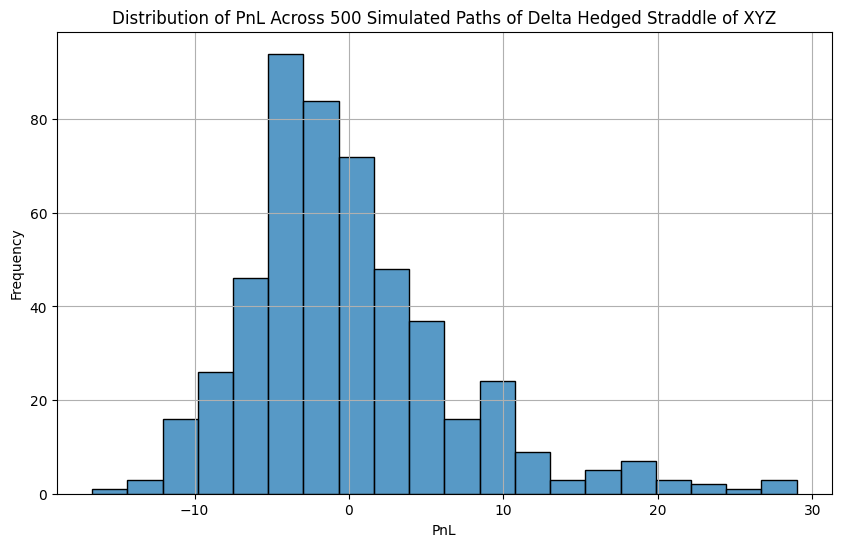

In [194]:
plt.figure(figsize=(10,6))
sns.histplot(data = hedged_pnls, bins = 20) 
plt.title('Distribution of PnL Across 500 Simulated Paths of Delta Hedged Straddle of XYZ')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.grid() 
plt.show()

### 2e

Run regressions of the cumulative pnl on the stock price on the expiration date and on the realized variance

In [197]:
Y = hedged_pnls
X_price = expiration_prices.values 
X_rv = realized_variance.values 

In [198]:
#Regression 1 
X1 = sm.add_constant(X_price)
model1 = sm.OLS(Y, X1).fit() 

print("=== Regression 1: PnL on S_T ===")
print(f"Intercept (alpha): {model1.params[0]:.4f}")
print(f"Coefficient (beta): {model1.params[1]:.4f}")
print(f"R-squared: {model1.rsquared:.4f}")
print("-" * 30)

=== Regression 1: PnL on S_T ===
Intercept (alpha): 5.2161
Coefficient (beta): -0.0452
R-squared: 0.0426
------------------------------


In [199]:
X2 = sm.add_constant(X_rv)
model2 = sm.OLS(Y, X2).fit() 

print("=== Regression 2: PnL on RV ===")
print(f"Intercept (alpha): {model2.params[0]:.4f}")
print(f"Coefficient (beta): {model2.params[1]:.4f}")
print(f"R-squared: {model2.rsquared:.4f}")
print("-" * 30)

=== Regression 2: PnL on RV ===
Intercept (alpha): -7.4469
Coefficient (beta): 94.0571
R-squared: 0.6202
------------------------------
